In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import japanize_matplotlib
from causalnex.structure.notears import from_pandas
from sklearn.preprocessing import StandardScaler

In [ ]:
def processing_df(df):
    df.drop(["Unnamed: 0","year", "area", "code", "総人口"], axis=1, inplace=True)
    df.replace("-", 0, inplace=True)
        
def calc_changing_rate(df_prev, df):
    df_cr = (df - df_prev + 0.01) / (df_prev + 0.01)
    return df_cr

def scaler(x):
    return (2 / (1 + math.exp(-2*x))) - 1

def structure_learning(df, threshold=None, max_iter=None):
    input_tr = df.applymap(scaler)
    return from_pandas(input_tr, w_threshold=threshold, max_iter=max_iter)

def make_color_list(dag, target_node):
    if target_node not in dag.nodes:
        raise ValueError(f"target_node {target_node} is not in the graph")
    
    incoming_edges = dag.in_edges(target_node)
    source_nodes = [edge[0] for edge in incoming_edges]
    print(f"source_nodes: {source_nodes}")
    
    node_color = []
    edge_color = []
    for node in dag.nodes:
        if node == target_node:
            node_color.append("red")
        elif node in source_nodes:
            node_color.append("blue")
        else:
            node_color.append("gray")
            
    for edge in dag.edges:
        if edge in incoming_edges:
            edge_color.append("blue")
        else:
            edge_color.append("black")
            
    return node_color, edge_color
    

def plot_struct(dag, node_color, edge_color, labels, title, figsize=(15, 15)):
    pos = nx.circular_layout(dag)
    plt.figure(figsize=figsize)
    nx.draw(dag, pos=pos, with_labels=False, node_color=node_color, edge_color=edge_color,font_family="Osaka")
    nx.draw_networkx_labels(dag, pos=pos, labels=labels, font_family="Osaka")
    plt.title(title)
    plt.show()

In [ ]:
# 年度ごとのデータ
df00 = pd.read_excel("/Users/itsukikuwahara/Desktop/codes/research/data/data1.xlsx", sheet_name="2000")
df05 = pd.read_excel("/Users/itsukikuwahara/Desktop/codes/research/data/data1.xlsx", sheet_name="2005")
df10 = pd.read_excel("/Users/itsukikuwahara/Desktop/codes/research/data/data1.xlsx", sheet_name="2010")
df15 = pd.read_excel("/Users/itsukikuwahara/Desktop/codes/research/data/data1.xlsx", sheet_name="2015")

In [29]:
# 不要な列を削除
processing_df(df00)
processing_df(df05)
processing_df(df10)
processing_df(df15)

# 必要な増減率を計算
df00_05 = calc_changing_rate(df00, df05)
df05_10 = calc_changing_rate(df05, df10)
df10_15 = calc_changing_rate(df10, df15)

In [30]:
# データを結合して、全体のデータフレームを作成
all_df = pd.concat([df00_05, df05_10, df10_15], axis=0)
all_df.dropna(inplace=True)
all_df.reset_index(drop=True, inplace=True)

In [31]:
sl = structure_learning(all_df, threshold=0.1, max_iter=1000)

source_nodes: ['一般診療所数/10万人', '一般診療所数/可住地面積', '自市区町村で従業・通学している人口']


AttributeError: 'list' object has no attribute 'items'

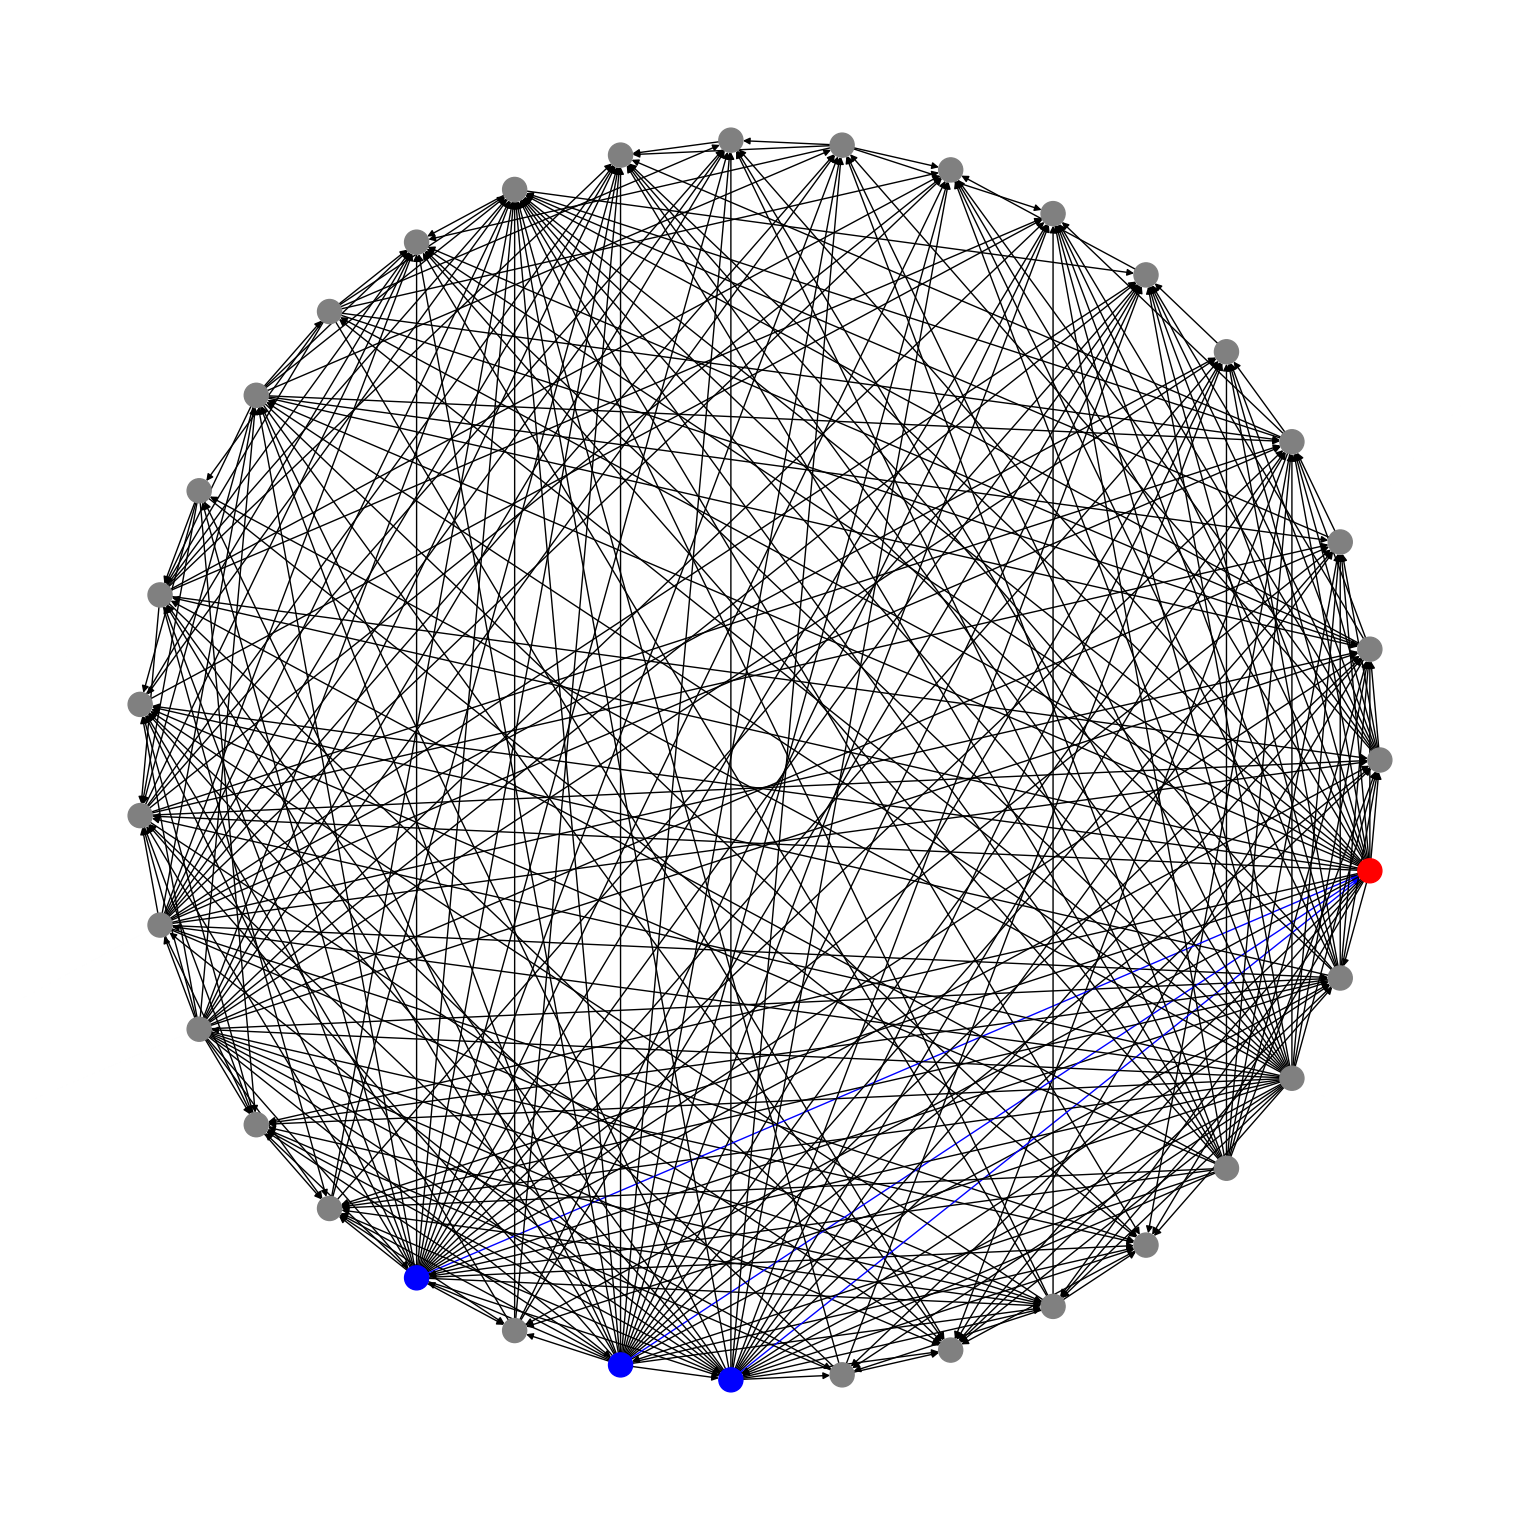

In [34]:
node_color, edge_color = make_color_list(sl, target_node="若年層人口")
plot_struct(sl, node_color, edge_color, labels=node_color, title="若年層人口のDAG推定",figsize=(15, 15))